<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# London Transport Network

---

This dataset obtained from [Manlio De Domenico's webpage](https://comunelab.fbk.eu/data.php) (direct file link: [London Multiplex Transport](https://comunelab.fbk.eu/data/London_Multiplex_Transport.zip), put the unzipped folder into the same folder as this notebook) contains data about the London Transport Network of tube, overground and DLR connecting 369 stations.  Additionally, it contains data about disruptions in the network collected from Twitter. A detailed description of the dataset by the authors is included. 

The files contain the following information:
1. *london_transport_raw.edges*: the individual lines and the stations they connect
2. *london_transport_nodes.txt*: the stations, their ID, and their coordinates
3. *london_transport_multiplex.edges*: the first column indicates if the connection is through tube (1), overground (2) or DLR (3). The second and third column indicate the corresponding link through the station IDs. The fourth column indicates how many different lines run between these two nodes (that is only relevant for the tube).
4. *london_transport_disruptions_summary.txt*: summary statistics about the recorded disruptions for the individual lines and links.
5. A folder with the disruptions that occured giving each time the network with the links existing during the disruption.

The dataset actually consists of three networks, one for the tube, one for the overground and one for the DLR, all connecting the same nodes. One can consider these networks separately or, as passengers can use all three of them, the combined network. In that case one speaks of a multiplex network.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
plt.style.use('ggplot') 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [224]:
df_raw = pd.read_csv('./London_Multiplex_Transport/Dataset/london_transport_raw.edges',sep=' ',header=None)
df_raw.columns = ['line','station_1','station_2']
print(df_raw.shape)
df_raw.head()

(503, 3)


,line,station_1,station_2
0,bakerloo,harrow&wealdstone,kenton
1,bakerloo,kenton,southkenton
2,bakerloo,southkenton,northwembley
3,bakerloo,northwembley,wembleycentral
4,bakerloo,wembleycentral,stonebridgepark


In [3]:
df_raw.line.unique()

array(['bakerloo', 'central', 'circle', 'district', 'hammersmith&city',
       'jubilee', 'metropolitan', 'northern', 'piccadilly', 'victoria',
       'waterloo&city', 'overground', 'dlr'], dtype=object)

In [4]:
df_nodes = pd.read_csv('./London_Multiplex_Transport/Dataset/london_transport_nodes.txt',sep=' ')
print(df_nodes.shape)
df_nodes.head()

(369, 4)


,nodeID,nodeLabel,nodeLat,nodeLong
0,0,abbeyroad,51.531952,0.003738
1,1,westham,51.528526,0.005332
2,2,actoncentral,51.508758,-0.263416
3,3,willesdenjunction,51.532234,-0.243895
4,4,actontown,51.503071,-0.280288


In [5]:
df_multiplex = pd.read_csv('./London_Multiplex_Transport/Dataset/london_transport_multiplex.edges',sep=' ',header=None)
df_multiplex.columns = ['layer','node_1','node_2','weight']
print(df_multiplex.shape)
df_multiplex.head()

(441, 4)


,layer,node_1,node_2,weight
0,1,1,77,2
1,1,1,106,1
2,1,1,219,1
3,1,1,321,2
4,1,3,224,1


In [7]:
df_disruption_sum = pd.read_csv('./London_Multiplex_Transport/Dataset/london_transport_disruptions_summary.txt',sep=' ')
print(df_disruption_sum.shape)
df_disruption_sum.head()

(325, 6)


,#DISRUP_ID,LAYER,STATION_A,STATION_B,FREQUENCY%,DAMAGED_NODES%
0,DISR1,metropolitan,aldgate,bakerstreet,3.3457,2.439
1,DISR2,hammersmith&city,barking,moorgate,2.8914,3.523
2,DISR3,dlr,beckton,canningtown,2.5609,2.439
3,DISR4,overground,claphamjunction,surreyquays,2.0240,1.897
4,DISR5,overground,richmond,willesdenjunction,1.9413,1.626


In [8]:
df_layers = pd.read_csv('./London_Multiplex_Transport/Dataset/london_transport_layers.txt',sep='\t')
df_layers['layerID'] = [int(x[0]) for x in list(df_layers.iloc[:,0])]
df_layers['layerLabel'] = [x[2:] for x in list(df_layers.iloc[:,0])]
df_layers.drop(df_layers.columns[0],axis=1,inplace=True)
df_layers.head()

,layerID,layerLabel
0,1,Tube (All underground lines aggregated)
1,2,Overground
2,3,DLR


In [9]:
df_multiplex[df_multiplex.layer==1].loc[:,'node_1':].head()
# weight = how many lines are operating between nstsat

,node_1,node_2,weight
0,1,77,2
1,1,106,1
2,1,219,1
3,1,321,2
4,3,224,1


In [10]:
df_multiplex[df_multiplex.layer==1].describe()

,layer,node_1,node_2,weight
count,312.0,312.000000,312.000000,312.000000
mean,1.0,130.804487,209.314103,1.198718
std,0.0,97.611328,103.419652,0.459552
min,1.0,1.000000,5.000000,1.000000
25%,1.0,44.000000,127.000000,1.000000
50%,1.0,116.000000,219.000000,1.000000
75%,1.0,205.250000,299.000000,1.000000
max,1.0,367.000000,368.000000,3.000000


## Construct the graphs:

* Which graphs would you like to construct?
* Which variables would you take as nodes and edges?
* Select the corresponding data from the above dataframes and transform to numpy array format using `.values`.
* Construct empty graphs, then add the nodes and the edges. You can insert lists of nodes and edges using the networkx functions `add_nodes_from` and `add_edges_from`.
* For each graph that you construct, indicate the number of nodes and edges.

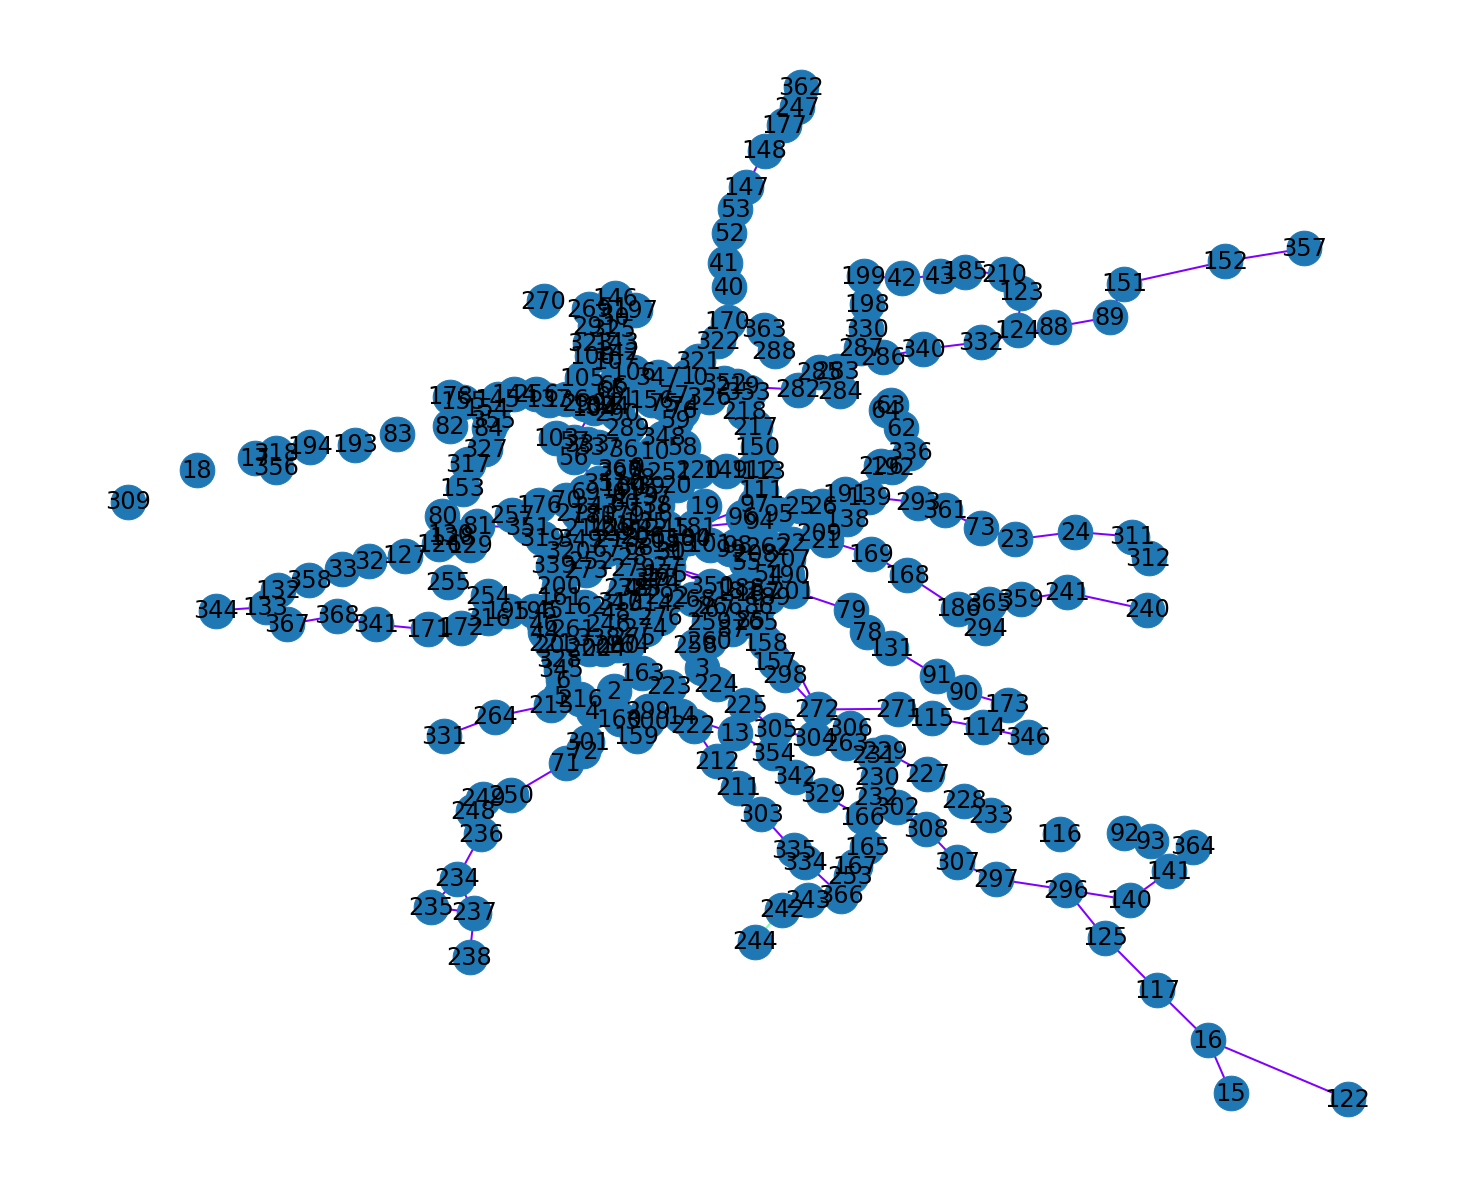

In [155]:
# !!!!!
# Look at the solution to see this properly... because Christophe split this into 3 different maps, and ensured
# we had add_nodes_from so that all nodes are reflected in each graph's visualisation.
# That's all we need add_nodes_from for here, as add_weighted_edges has all the nodes and weights data housed.
# !!!!!

# filter for layer 1 to prepare df
df_layer_1 = df_multiplex[df_multiplex['layer']==1].loc[:,'node_1':]
df_layer_2 = df_multiplex[df_multiplex['layer']==2].loc[:,'node_1':]
df_layer_3 = df_multiplex[df_multiplex['layer']==3].loc[:,'node_1':]

# generate the empty graphs
G1 = nx.Graph()
G1.add_nodes_from(range(df_multiplex[['node_1','node_2']].min().min(),
                        df_multiplex[['node_1','node_2']].max().max()))
G1.add_weighted_edges_from(df_layer_1.values)

G2 = nx.Graph()
G2.add_nodes_from(range(df_multiplex[['node_1','node_2']].min().min(),
                        df_multiplex[['node_1','node_2']].max().max()))
G2.add_weighted_edges_from(df_layer_2.values)

G3 = nx.Graph()
G3.add_nodes_from(range(df_multiplex[['node_1','node_2']].min().min(),
                        df_multiplex[['node_1','node_2']].max().max()))
G3.add_weighted_edges_from(df_layer_3.values)

# plot color-mapped weighted graph
# positions = {k:v for k,v in zip(df_nodes.nodeID, zip(df_nodes.nodeLat,df_nodes.nodeLong))}
edge_weights1 = [e[2]['weight'] for e in G1.edges(data=True)]
edge_weights2 = [e[2]['weight'] for e in G2.edges(data=True)]
edge_weights3 = [e[2]['weight'] for e in G3.edges(data=True)]

plt.figure(figsize=(10,8))
nx.draw(G1, pos=positions, with_labels=True, edge_color=edge_weights1, edge_cmap=cmap_edges)

## Plot the networks that you constructed

* Add the edges from all graphs to your plot.
* Color the edges according to if they belong to the tube, the overground or the DLR.
* Use the option `pos` in the drawing function to position the nodes according to their longitudinal and latitudinal coordinates. You have to provide a dictionary with node IDs as keys and coordinates as values.

In [75]:
df_multiplex.head()

,layer,node_1,node_2,weight
0,1,1,77,2
1,1,1,106,1
2,1,1,219,1
3,1,1,321,2
4,1,3,224,1


In [139]:
df_multiplex.layer.shape

(441,)

In [140]:
G.number_of_edges()

430

## What is the diameter of your networks? 

* The diameter is the longest of all shortest paths between any two points.
* Take the largest connected component for that. You can obtain the connected subgraphs with the networkx command `connected_component_subgraphs`.
* You can obtain the diameter of a connected component with the networkx command `diameter`.

In [156]:
a = list(dict(nx.shortest_path_length(G)).values())
diameter1 = max([max(a[i].values()) for i in range(len(a))])

b = list(dict(nx.shortest_path_length(G1)).values())
diameter2 = max([max(b[i].values()) for i in range(len(b))])

c = list(dict(nx.shortest_path_length(G2)).values())
diameter3 = max([max(c[i].values()) for i in range(len(c))])

d = list(dict(nx.shortest_path_length(G3)).values())
diameter4 = max([max(d[i].values()) for i in range(len(d))])

In [158]:
[diameter1,diameter2,diameter3,diameter4]

[39, 39, 35, 23]

In [135]:
len(list(nx.connected_component_subgraphs(G)))

In [136]:
nx.info(list(nx.connected_component_subgraphs(G))[0].subgraph(G))

'Name: \nType: Graph\nNumber of nodes: 369\nNumber of edges: 430\nAverage degree:   2.3306'

## Get the shortest path between any two stations

* Write a function which takes your network graph, the starting and the end station as arguments. It should return the length of the shortest path between them, the intermediate stations and which lines you have to take.
* Which is the shortest path for getting from Aldgate East to South Kensington? 
* Is that the connection you would choose? 
* What information would you like to add to your network to obtain a better recommendation? How would you add it? (Not required to do that explicitly now.)

Hint: Use the networkx commands `shortest_path` and `shortest_path_length`.

In [214]:
def your_shortest_path(G,start_station,end_station):
    A = df_nodes[df_nodes['nodeLabel']=='{}'.format(start_station)]['nodeID'].values[0]
    B = df_nodes[df_nodes['nodeLabel']=='{}'.format(end_station)]['nodeID'].values[0]
    
    return nx.shortest_path_length(G, A, B), nx.shortest_path(G, A, B)

    for i in len(nx.shortest_path(G, A, B)):
        

In [215]:
your_shortest_path(G, 'aldgateeast', 'southkensington')

(8, [9, 8, 34, 180, 214, 67, 252, 273, 200])

In [227]:
# df_raw = df_raw.merge(df_nodes[['nodeID','nodeLabel']], how='left', left_on='station_1', right_on='nodeLabel')
# df_raw = df_raw.merge(df_nodes[['nodeID','nodeLabel']], how='left', left_on='station_2', right_on='nodeLabel')
# df_raw.rename(columns={'nodeID_x':'nodeID_1','nodeID_y':'nodeID_2'}, inplace=True)
# df_raw.drop(columns=['nodeLabel_x','nodeLabel_y'], inplace=True)
df_raw.head()

,line,station_1,station_2,nodeID_1,nodeID_2
0,bakerloo,harrow&wealdstone,kenton,227,229
1,bakerloo,kenton,southkenton,229,263
2,bakerloo,southkenton,northwembley,263,304
3,bakerloo,northwembley,wembleycentral,304,305
4,bakerloo,wembleycentral,stonebridgepark,305,225


## Plot the degree distributions of your graphs

## Obtain the betweenness for the nodes in the tube, overground and DLR networks

* Which are the 10 most important nodes for the score in each network?
* Are there correlations among these node rankings?

Hint: Use the networkx command `betweenness_centrality`.

## Optional (open ended):

Look at the disruption data. 
* How do the individual disruptions affect the connectivity, path length and betweenness of the network? Look first at just one of the disruptions.

In [11]:
list_disruptions = !ls London_Multiplex_Transport/Dataset/Disruptions/
len(list_disruptions)

325

In [12]:
df_disruptions_1 = pd.read_table('London_Multiplex_Transport/Dataset/Disruptions/'+list_disruptions[1],sep=' ',header=None)
df_disruptions_1.columns = ['layer','node_1','node_2','weight']
df_disruptions_1.head()

,layer,node_1,node_2,weight
0,1,1,106,1
1,1,1,219,1
2,1,1,321,2
3,1,1,77,2
4,1,3,224,1
